## init

In [43]:
%matplotlib widget
# import sys 
# sys.path.append('pyfiles/')

from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils
)

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
import math
from collections import defaultdict
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance
from scipy.stats import qmc
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import csv
import string

# for polygon grid
from matplotlib.path import Path as mplPath

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## this is the new, streamlined thing

In [ ]:
our_complex = inp.read_obj("input/blob.obj")
key_point1 = (0.4, 0.6)
key_point2 = (0.6, 0.6)
o = cplx.ordering.by_dist_to(our_complex, key_point1)
o2 = cplx.ordering.by_dist_to(our_complex, key_point2)
matrix = mat.bdmatrix.from_ordering(o)
# with ourplot.PandasMatrix(matrix, o) as p:
#     matrix.reduce(every_step=p.every_step)

bettis = defaultdict(int)
def after_column_reduced(mat, j):
    if mat.get(j, set()):
        death = o.get_simplex(j)
        birth = o.get_simplex(max(mat.get(j, set())))
        bettis[birth.dim()] -= 1
        print(f'col {j}:')
        print(f'  birth={birth}')
        print(f'  death={death}')
    else:
        s = o.get_simplex(j)
        bettis[s.dim()] += 1
        print(f'col {j}: reduced to zero: {s}')

ourplot.plot_orders_with_bubbles(o, o2)

In [110]:
our_complex = inp.read_obj("input/blob.obj")
key_point1 = (0.75, 0.40)
key_point2 = (0.75, 0.25)
o = cplx.ordering.by_dist_to(our_complex, key_point1)
o2 = cplx.ordering.by_dist_to(our_complex, key_point2)
matrix = mat.bdmatrix.from_ordering(o)

n = our_complex.nedges() + our_complex.nverts() + 1
V = np.eye(n, dtype=int)
def record_column_adds(sparsemat, indices, old_column):
  V[:, indices[0]] = (V[:, indices[0]] + V[:, indices[1]]) % 2

matrix.reduce(every_step=record_column_adds);
assert (((matrix.initmatrix @ V) % 2) == matrix.reduced).all(), 'Something is wrong with the column reduction'

U = np.absolute(np.linalg.inv(V).astype(int)) % 2

assert (((U @ V) % 2) == np.eye(n, dtype=int)).all(), 'U@V didn\'t give identity matrix'
assert (((V @ U) % 2) == np.eye(n, dtype=int)).all(), 'V@U didn\'t give identity matrix'



In [111]:
our_complex = inp.read_obj("input/triangle.obj")
key_point1 = (0.75, 0.40)
o = cplx.ordering.by_dist_to(our_complex, key_point1)
matrix = mat.bdmatrix.from_ordering(o)

knowledge = mat.reduction_knowledge(matrix, o)
knowledge.run()

# R = DV
D = matrix.initmatrix
R = matrix.reduced

V = np.eye(D.shape[0], dtype=int);
for (target, other) in knowledge.adds:
  V[:, target] = (V[:, target] + V[:, other]) % 2
assert (((D @ V) % 2) == R).all(), 'Something is wrong with the column reduction'

# RU = D
U = vin.matrix_inverse(V)

assert (((R @ U) % 2) == D).all(), 'Something is wrong with the column reduction'


for i in range(0, R.shape[0] - 1):
  P = vin.permutation_matrix(R.shape[0], i, i + 1)
  PDP = (P.T @ D @ P) % 2
  (RR, UU, faustian_swap) = vin.perform_one_swap(i, knowledge, R, U)
  RRUU = (RR @ UU) % 2
  assert (RRUU == PDP).all(), 'Something is wrong with the column reduction'


y = -1.0
pt_i = 0
reduction start
reduction end
inverse start
inverse end
swapped_indices = #8
pt_i = 1
swapped_indices = #12
pt_i = 2
swapped_indices = #30
pt_i = 3
swapped_indices = #52
pt_i = 4
swapped_indices = #71
pt_i = 5
swapped_indices = #74
pt_i = 6
swapped_indices = #52
pt_i = 7
swapped_indices = #30
pt_i = 8
swapped_indices = #11
pt_i = 9
swapped_indices = #8
y = -0.7777777777777778
pt_i = 0
reduction start
reduction end
inverse start
inverse end
swapped_indices = #8
pt_i = 1
swapped_indices = #16
pt_i = 2
swapped_indices = #26
pt_i = 3
swapped_indices = #42
pt_i = 4
swapped_indices = #85
pt_i = 5
swapped_indices = #88
pt_i = 6
swapped_indices = #42
pt_i = 7
swapped_indices = #26
pt_i = 8
swapped_indices = #15
pt_i = 9
swapped_indices = #8
y = -0.5555555555555556
pt_i = 0
reduction start
reduction end
inverse start
inverse end
swapped_indices = #8
pt_i = 1
swapped_indices = #14
pt_i = 2
swapped_indices = #28
pt_i = 3
swapped_indices = #36
pt_i = 4
swapped_indices = #96
pt_i 

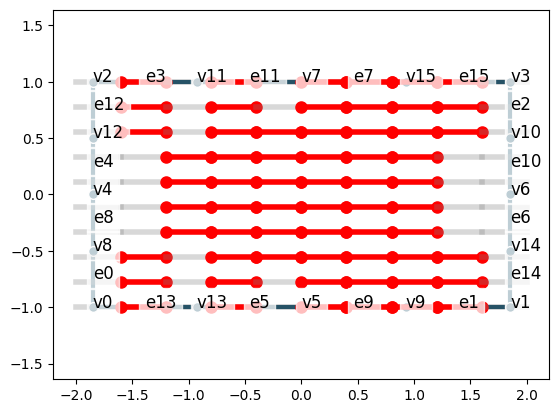

In [3]:

our_complex = inp.read_obj("input/rectangle-4.obj")
ourplot.plot_complex(our_complex, label_edges=True, label_verts=True)
key_point1 = (0.0, 0.6)

N = 10
for y in np.linspace(-1.0, 1, N):
  print(f'y = {y}')
  def get_pairs_of_points(i, n):
    return (
      [ -2 + 4 / n *  i, y],
      [-2 + 4 / n * (i+1), y]
    )

  for pt_i in range(0, N):
    print(f'pt_i = {pt_i}')
    (key_point1, key_point2) = get_pairs_of_points(pt_i, N)
    if pt_i == 0:
      o1 = cplx.ordering.by_dist_to(our_complex, key_point1)

      matrix = mat.bdmatrix.from_ordering(o1)
      knowledge = mat.reduction_knowledge(matrix, o1)
      print(f'reduction start')
      knowledge.run()
      print(f'reduction end')

      # R = DV
      D = matrix.initmatrix
      R = matrix.reduced

      V = np.eye(D.shape[0], dtype=int);
      for (target, other) in knowledge.adds:
        V[:, target] = (V[:, target] + V[:, other]) % 2
      assert (((D @ V) % 2) == R).all(), 'Something is wrong with the column reduction'

      # RU = D
      print(f'inverse start')
      U = vin.matrix_inverse(V)
      print(f'inverse end')
      assert (((R @ U) % 2) == D).all(), 'Something is wrong with the column reduction'

    o1 = cplx.ordering.by_dist_to(our_complex, key_point1)
    o2 = cplx.ordering.by_dist_to(our_complex, key_point2)
    (swapped_simplices, _, swapped_indices) = o1.compute_transpositions(o2)

    found_faustian = False
    print(f'swapped_indices = #{len(swapped_indices)}')
    for (swap_i, i) in enumerate(swapped_indices):
      P = vin.permutation_matrix(R.shape[0], i, i + 1)
      PDP = (P.T @ D @ P) % 2
      (RR, UU, faustian_swap) = vin.perform_one_swap(i, knowledge, R, U)

      if faustian_swap:
        found_faustian = True

      RRUU = (RR @ UU) % 2
      # assert (RRUU == PDP).all(), 'Something is wrong with the column reduction'
      R = RR
      U = UU
      D = PDP

    # f = 0.5
    # pt = (1 - f) * np.array(key_point1) + f * np.array(key_point2)
    if found_faustian:
      plt.plot([key_point1[0], key_point2[0]], [key_point1[1], key_point2[1]], 'o-', markersize=8, linewidth=4, color='red' )
    else:
      plt.plot([key_point1[0], key_point2[0]], [key_point1[1], key_point2[1]], '-', alpha=0.3, linewidth=4, color='gray' )



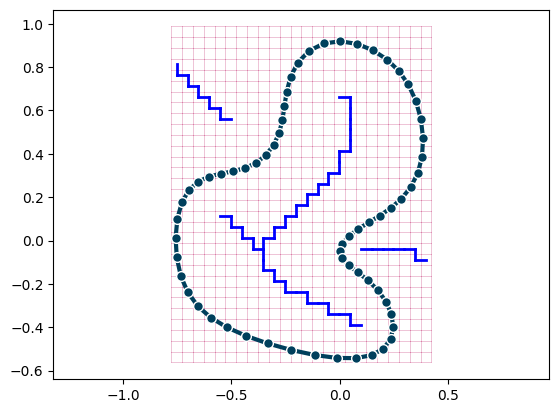

In [12]:
# Load input file
# our_complex = inp.read_obj("input/triangle-.obj")
# key_point1 = (0.0, 0.6)
# gridd = grid.Grid.from_complex(our_complex, 0.1, buffer=0.05)

# our_complex = inp.read_obj("input/equilateral-triangle-medium.obj")
# key_point1 = (0.0, 0.6)
# gridd = grid.Grid.from_complex(our_complex, 0.03, buffer=0.19123)

# our_complex = inp.read_obj("input/rectangle-8.obj")
# key_point1 = (0.0, 0.6)
# gridd = grid.Grid.from_complex(our_complex, 0.1, buffer=0.1)

our_complex = inp.read_obj("input/bob.obj")
key_point1 = (0.0, 0.6)
gridd = grid.Grid.from_complex(our_complex, 0.05, buffer=0.02)

# Plot things
fig,ax = plt.subplots()
ax.set_aspect('equal')
ourplot.plot_grid(ax, gridd)
ourplot.plot_complex(our_complex, label_verts=False, ax=ax)

our_complex.check_simplex_indices_are_okay()

ma_edges = []

n = gridd.edge_indices.shape[0]
for i in range(0, n):
  print(f'Progress: {int(100 * i / n)}%\r', end='')

  if gridd.is_boundary_edge(i):
    continue
  [p1, p2] = gridd.edge_indices[i]

  p = gridd.points[p1]
  q = gridd.points[p2]

  faustian,tricksy = vin.do_vineyards_for_two_points(our_complex, p, q, 0)

  if faustian and not tricksy:
    a, b = gridd.dual_edge(i)
    ax.plot([a[0], b[0]], [a[1], b[1]], '-', linewidth=2, color='blue')
    ma_edges.append((a, b))
  if tricksy:
    a, b = gridd.dual_edge(i)
    ax.plot([a[0], b[0]], [a[1], b[1]], '-', linewidth=2, color='orange')
  # else:
  #   ax.plot([p[0], q[0]], [p[1], q[1]], '-', markersize=1, linewidth=1, color='gray')

# utils.Timed.report()

# with open('ma.obj', 'w') as f:
#   vi = 0
#   for (a, b) in ma_edges:
#     f.write(f'v {a[0]} {a[1]} 0.0\n')
#     f.write(f'v {b[0]} {b[1]} 0.0\n')
#     f.write(f'l {vi + 1} {vi + 2}\n')
#     vi += 2

Before:
```
|======== Timed report ========
|  vineyard from scratch:    3110.95ms
|               create V:     381.82ms
|               create U:    3853.44ms
|               create B:     354.09ms
| compute_transpositions:     868.95ms
|               do swaps:    5652.22ms
|==============================
```

after `make_permutation_fn`

```
|======== Timed report ========
|  vineyard from scratch:    3286.32ms
|               create V:     381.87ms
|               create U:    3187.63ms
|               create B:     352.47ms
| compute_transpositions:     893.32ms
|               do swaps:    3288.05ms
|==============================
```


Baseline with all the sparse stuff. No good
```
|======== Timed report ========
|  vineyard from scratch:    2330.25ms
|               create V:     422.58ms
|               create U:    8046.45ms
|               create B:     271.78ms
| compute_transpositions:     579.92ms
|               do swaps:   26198.17ms
|==============================
```

Making `D` sparse:
```
|======== Timed report ========
|                        vineyard from scratch:    2321.10ms
|                                     create V:     410.17ms
|                                     create U:    7958.61ms
|                       create ordering from B:     267.13ms
| compute_transpositions between the orderings:     577.01ms
|                                     do swaps:   36702.27ms
|==============================
```


2.37 seconds to run this:
```
our_complex = inp.read_obj("input/bob.obj")
key_point1 = (0.0, 0.6)
gridd = grid.Grid.from_complex(our_complex, 0.02, buffer=0.02)

|======== Timed report ========
| Reduction from scratch                      :   54849.20ms  ( 6.105ms per; #8984)
| create V [check]                            :    8638.46ms  ( 0.962ms per; #8984)
| create V                                    :    8919.70ms  ( 0.993ms per; #8984)
| create U [gf_v]                             :     760.30ms  ( 0.085ms per; #8984)
| create U [gv_inv]                           :   59009.68ms  ( 6.568ms per; #8984)
| create U [U_t]                              :    7647.33ms  ( 0.851ms per; #8984)
| create U [check]                            :    8927.80ms  ( 0.994ms per; #8984)
| create U                                    :   76391.14ms  ( 8.503ms per; #8984)
| create ordering from B                      :    2141.49ms  ( 0.238ms per; #8984)
| compute_transpositions.setup                :      76.77ms  ( 0.009ms per; #8984)
| compute_transpositions.loop                 :    6705.54ms  ( 0.746ms per; #8984)
| compute_transpositions between the orderings:    6813.62ms  ( 0.758ms per; #8984)
| vineyards.step                              :   11015.75ms  ( 1.226ms per; #8984)
|==============================
```



and here's one more:

```
our_complex = inp.read_obj("input/bob.obj")
key_point1 = (0.0, 0.6)
gridd = grid.Grid.from_complex(our_complex, 0.04, buffer=0.02)

|======== Timed report ========
| Reduction                :   13457.62ms  ( 6.084ms per; #2212)
| Vineyards.setup: D, R    :     853.35ms  ( 0.386ms per; #2212)
| Vineyards.setup: create V:      66.97ms  ( 0.030ms per; #2212)
| Vineyards.setup: create U:   18839.93ms  ( 8.517ms per; #2212)
| Vineyards: new ordering  :     542.63ms  ( 0.245ms per; #2212)
| Vineyards: transpositions:    3237.46ms  ( 1.464ms per; #2212)
| Vineyards: repair        :     967.40ms  ( 0.437ms per; #2212)
| Vineyards                :    4755.30ms  ( 2.150ms per; #2212)
|==============================
```

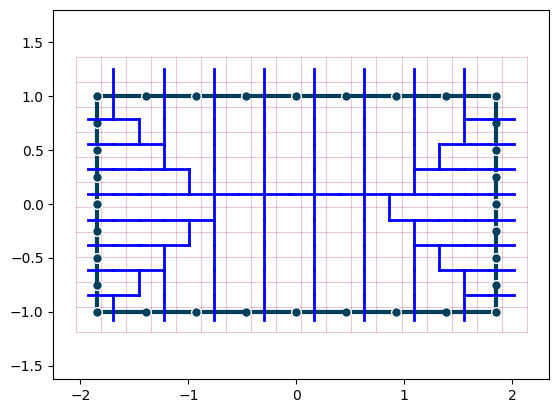

In [120]:
from pyfiles import demo
demo.make_demos()

<Axes: >

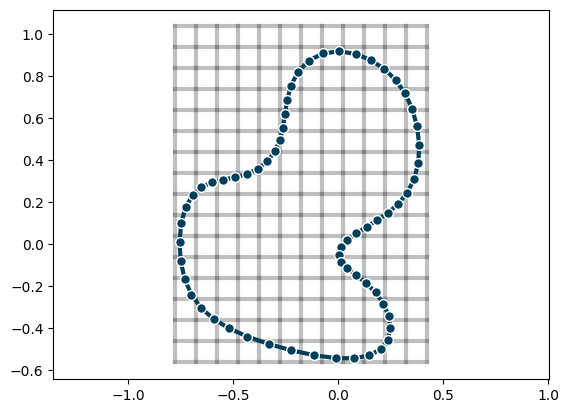

In [3]:

our_complex = inp.read_obj("input/bob.obj")
key_point1 = (0.0, 0.6)
gridd = grid.Grid.from_complex(our_complex, 0.1, buffer=0.02)

# Plot things
fig,ax = plt.subplots()
ax.set_aspect('equal')
# ourplot.plot_grid(ax, gridd)

def visit_an_edge(new_point, old_point):
  if old_point is None:
    return
  p = gridd.points[new_point]
  q = gridd.points[old_point]
  ax.plot(
    [p[0], q[0]], [p[1], q[1]], '-', markersize=1, linewidth=3, color='gray', alpha=0.5
  )

start_index = len(gridd.points) // 2
bad_points = gridd.flood_fill_visit(start_index, visit_an_edge)
ourplot.plot_complex(our_complex, label_verts=False, ax=ax)

|======== Timed report ========
| initialize_vineyards            :      17.40ms  (17.397ms per; #1)
| vine_to_vine.ordering           :     376.13ms  ( 0.262ms per; #1433)
| vine_to_vine.transpositions_lean:     380.14ms  ( 0.265ms per; #1433)
| vine_to_vine.matrix copies      :    2571.98ms  ( 1.795ms per; #1433)
| perform_one_swap                :    3384.80ms  ( 0.012ms per; #277481)
| dumb loop here                  :    2728.98ms  ( 0.039ms per; #69323)
| vine_to_vine.loop               :    3689.03ms  ( 2.574ms per; #1433)
|==============================


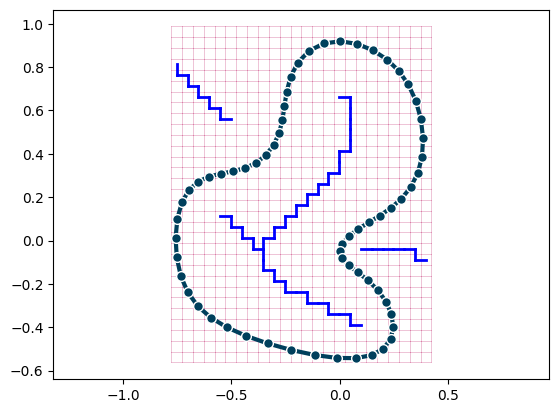

In [33]:
from typing import Optional


our_complex = inp.read_obj("input/bob.obj")
key_point1 = (0.0, 0.6)
gridd = grid.Grid.from_complex(our_complex, 0.05, buffer=0.02)

# Plot things
fig,ax = plt.subplots()
ax.set_aspect('equal')
ourplot.plot_grid(ax, gridd)
ourplot.plot_complex(our_complex, label_verts=False, ax=ax)

our_complex.check_simplex_indices_are_okay()


state = {}
faustian_edges = []
call_count = 0
def for_each_edge(new_point: int, old_point: Optional[int]):
  global call_count
  print(f'Progress: {int(100 * call_count / gridd.edge_indices.shape[0])}%\r', end='')
  call_count += 1
  if old_point is None:
    if gridd.is_boundary_vertex(new_point):
      raise Exception('Dont start on the boundary!')
    special_point_a = gridd.points[new_point]
    state[new_point] = vin.initialize_vineyards(our_complex, special_point_a)
  else:
    if gridd.is_boundary_vertex(new_point) and gridd.is_boundary_vertex(old_point):
      return
    special_point_b = gridd.points[new_point]
    (D, R, U_t, a_ordering) = state[old_point]
    (faustian, new_D, new_R, new_U_t, b_ordering) = vin.vine_to_vine(
      D, R, U_t, our_complex, special_point_b, a_ordering, 0
    )
    state[new_point] = (new_D, new_R, new_U_t, b_ordering)
    if faustian:
      faustian_edges.append((old_point, new_point))


start_index = len(gridd.points) // 2 + 5
gridd.flood_fill_visit(start_index, for_each_edge)

for (a, b) in faustian_edges:
  a, b = grid.make_dual_edge(gridd.points[a], gridd.points[b])
  ax.plot([a[0], b[0]], [a[1], b[1]], '-', linewidth=2, color='blue')

utils.Timed.report()


### Before
```
|======== Timed report ========
| initialize_vineyards       :      17.30ms  (17.296ms per; #1)
| vine_to_vine.ordering      :     364.67ms  ( 0.254ms per; #1433)
| vine_to_vine.transpositions:    2544.10ms  ( 1.775ms per; #1433)
| vine_to_vine.matrix copies :    2561.69ms  ( 1.788ms per; #1433)
| vine_to_vine.loop          :   10838.42ms  ( 7.563ms per; #1433)
|==============================
```
### Remove empty sets in sneaky matrix
```
|======== Timed report ========
| initialize_vineyards       :      17.01ms  (17.007ms per; #1)
| vine_to_vine.ordering      :     394.57ms  ( 0.275ms per; #1433)
| vine_to_vine.transpositions:    2579.59ms  ( 1.800ms per; #1433)
| vine_to_vine.matrix copies :    2614.27ms  ( 1.824ms per; #1433)
| vine_to_vine.loop          :   10907.51ms  ( 7.612ms per; #1433)
|==============================
```



### Single call to `gives_birth`

```
|======== Timed report ========
| initialize_vineyards       :      16.78ms  (16.779ms per; #1)
| vine_to_vine.ordering      :     361.15ms  ( 0.252ms per; #1433)
| vine_to_vine.transpositions:    2627.15ms  ( 1.833ms per; #1433)
| vine_to_vine.matrix copies :    2438.68ms  ( 1.702ms per; #1433)
| perform_one_swap           :   11230.16ms  ( 0.040ms per; #277481)
| vine_to_vine.loop          :   11561.39ms  ( 8.068ms per; #1433)
|==============================
```
### No calls to `gives_birth`

```
|======== Timed report ========
| initialize_vineyards       :      17.47ms  (17.474ms per; #1)
| vine_to_vine.ordering      :     351.14ms  ( 0.245ms per; #1433)
| vine_to_vine.transpositions:    2593.56ms  ( 1.810ms per; #1433)
| vine_to_vine.matrix copies :    2551.76ms  ( 1.781ms per; #1433)
| perform_one_swap           :    3382.99ms  ( 0.012ms per; #277481)
| vine_to_vine.loop          :    3690.73ms  ( 2.576ms per; #1433)
|==============================
```




### Before vert map
```
|======== Timed report ========
| initialize_vineyards            :      17.01ms  (17.006ms per; #1)
| vine_to_vine.ordering           :     358.28ms  ( 0.250ms per; #1433)
| Suspicious                      :    1083.39ms  ( 0.004ms per; #277481)
| vine_to_vine.transpositions_lean:    1475.66ms  ( 1.030ms per; #1433)
| vine_to_vine.matrix copies      :    2314.61ms  ( 1.615ms per; #1433)
| perform_one_swap                :    3376.04ms  ( 0.012ms per; #277481)
| dumb loop here                  :    2724.11ms  ( 0.039ms per; #69323)
| vine_to_vine.loop               :    3680.36ms  ( 2.568ms per; #1433)
|==============================
```

### After
```
|======== Timed report ========
| initialize_vineyards            :      35.18ms  (17.590ms per; #2)
| vine_to_vine.ordering           :     702.14ms  ( 0.267ms per; #2632)
| Suspicious                      :    1855.09ms  ( 0.004ms per; #528608)
| vine_to_vine.transpositions_lean:    2592.36ms  ( 0.985ms per; #2632)
| vine_to_vine.matrix copies      :    4730.09ms  ( 1.797ms per; #2632)
| perform_one_swap                :    6494.28ms  ( 0.012ms per; #528608)
| dumb loop here                  :    5219.51ms  ( 0.040ms per; #132098)
| vine_to_vine.loop               :    7081.83ms  ( 2.691ms per; #2632)
|==============================
```

### TRy again
```
|======== Timed report ========
| initialize_vineyards            :      17.30ms  (17.305ms per; #1)
| vine_to_vine.ordering           :     372.36ms  ( 0.260ms per; #1433)
| Suspicious                      :     139.69ms  ( 0.001ms per; #277481)
| vine_to_vine.transpositions_lean:     527.64ms  ( 0.368ms per; #1433)
| vine_to_vine.matrix copies      :    2583.71ms  ( 1.803ms per; #1433)
| perform_one_swap                :    3375.11ms  ( 0.012ms per; #277481)
| dumb loop here                  :    2723.45ms  ( 0.039ms per; #69323)
| vine_to_vine.loop               :    3679.41ms  ( 2.568ms per; #1433)
|==============================
```

#t = 48


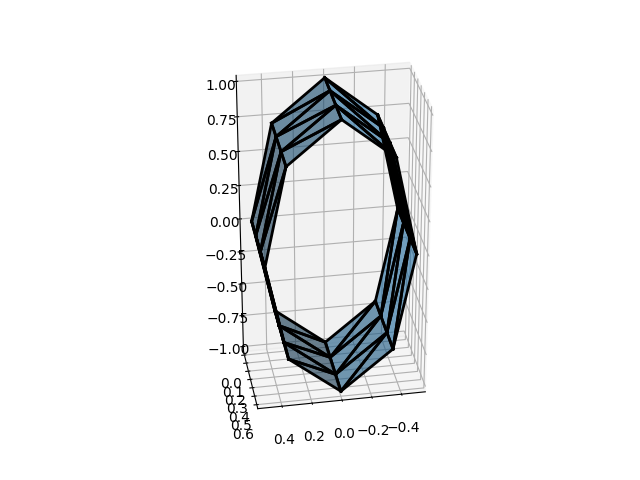

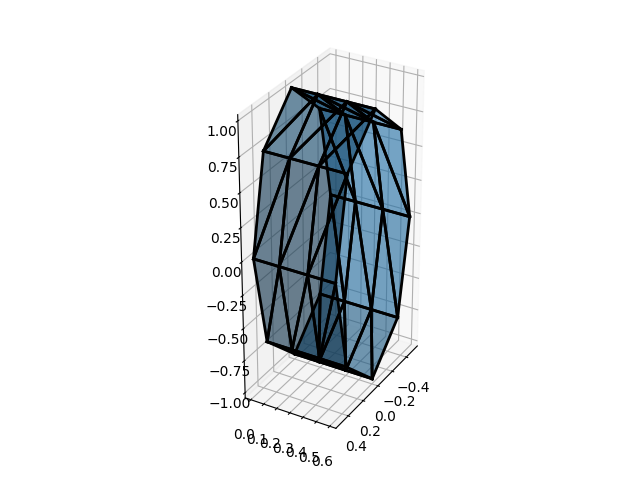

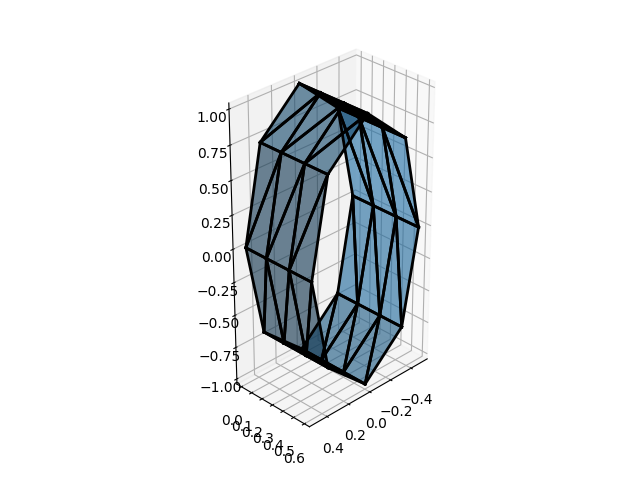

In [95]:
from matplotlib.widgets import Slider

our_complex = inp.read_obj("input/cylinder.obj")

for azim in [30, 45, 80]:
  fig, ax = plt.subplots(subplot_kw={'projection': '3d', 'computed_zorder': False})
  ax.view_init(azim=azim)
  ax.set_aspect('equal')
  ourplot.plot_complex_3d(ax, our_complex)
  ax.set_aspect('equal')

# key_point1 = (0.0, 0.6)

# gridd = grid.Grid.from_complex(our_complex, 0.05, buffer=0.02)

# # Plot things
# fig,ax = plt.subplots()
# ourplot.plot_grid(ax, gridd)
# ourplot.plot_complex(our_complex, label_verts=False, ax=ax)

# our_complex.check_simplex_indices_are_okay()
plt.show()



In [ ]:
from matplotlib import pyplot as plt 

# Plot
fig, ax = plt.subplots(subplot_kw={'projection': '3d', 'computed_zorder': False})

x = [0, 0.5, 0.5, 0]
y = [0, 0, 0.5, 0.5]
z = [-0.1, -0.1, -0.1, -0.1]

ax.set_aspect('equal')
ax.plot3D(x,y,z, linestyle='-', color='black')

x = [0, 1, 1, 0]
y = [0, 0, 1, 1]
z = [0, 0, 0, 0]

ax.plot_trisurf(
  x,y,z, triangles=[
    [0,1,2],
    [0,2,3],
  ],
  alpha=0.5
)

x = [0, 1, 1, 0]
y = [0, 0, 1, 1]
z = [0.1, 0.1, 0.1, 0.1]

ax.set_aspect('equal')
ax.plot(x,y,z, linestyle='-', color='black')




